In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from random import randint, choice
from tqdm import tqdm, trange
import time

In [2]:
img = plt.imread("base.jpg")
FINAL_SIZE = (1500, 1500)
PATCH_SIZE = (250, 250)
OVERLAP = 10
print(img.shape)

def template_match_ssd_with_mask(img, temp, mask):
    res = np.zeros((img.shape[0] - temp.shape[0] + 1, img.shape[1] - temp.shape[1] + 1))
    for i in range(img.shape[0] - temp.shape[0] + 1):
        for j in range(img.shape[1] - temp.shape[1] + 1):
            sq = np.square(img[i:i+temp.shape[0], j:j+temp.shape[1]] - temp)
            cost = np.sum(np.multiply(sq, mask))
            res[i][j] = cost
    return res

def get_random_patch(img, PATCH_SIZE):
    i = randint(0, img.shape[0] - PATCH_SIZE[0])
    j = randint(0, img.shape[1] - PATCH_SIZE[1])
    return img[i : i + PATCH_SIZE[0], j : j + PATCH_SIZE[1]]

def get_best_random_patch(img, temp, mask):
    res = template_match_ssd_with_mask(img, temp, mask)
#     print(len(np.argwhere(res <= 1.02*np.min(res))))
    ind = choice(np.argwhere(res <= 1.02*np.min(res)))
    return img[ind[0]:ind[0]+temp.shape[0], ind[1]:ind[1]+temp.shape[1]]

a = np.array([[0, 0, 0, 0 , 0], [0, 0, 1, 1, 0], [0, 0 ,1, 1, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], dtype=np.uint8)
b = np.array([[1, 1], [1, 0]], dtype=np.uint8)
t = time.time()
print(get_best_random_patch(a, b, np.ones_like(b)))

(400, 400, 3)
[[1 1]
 [1 1]]


100%|██████████| 7/7 [00:34<00:00,  4.93s/it]


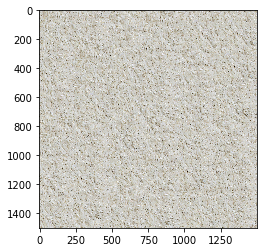

In [3]:
img_final = np.zeros((FINAL_SIZE[0], FINAL_SIZE[1], 3), dtype=np.uint8)

one_mask = np.ones(PATCH_SIZE)
left_mask = np.zeros(PATCH_SIZE)
top_mask = np.zeros(PATCH_SIZE)
top_left_mask = np.zeros(PATCH_SIZE)
left_mask[:, :OVERLAP] = 1
top_mask[:OVERLAP, :] = 1
top_left_mask[:, :OVERLAP] = 1
top_left_mask[:OVERLAP, :] = 1

for l in range(0, FINAL_SIZE[0], PATCH_SIZE[0] - OVERLAP):
    for k in trange(0, FINAL_SIZE[1], PATCH_SIZE[1] - OVERLAP):
        patch = img_final[l:l+PATCH_SIZE[0], k:k+PATCH_SIZE[1]]
        if patch.shape[0] < OVERLAP or patch.shape[1] < OVERLAP:
            continue
        if patch.shape != one_mask.shape:
            one_mask = np.ones_like(patch)
            left_mask = np.zeros_like(patch)
            top_mask = np.zeros_like(patch)
            top_left_mask = np.zeros_like(patch)
            left_mask[:, :OVERLAP] = 1
            top_mask[:OVERLAP, :] = 1
            top_left_mask[:, :OVERLAP] = 1
            top_left_mask[:OVERLAP, :] = 1
        if l == 0:
            if k == 0:
                res = get_random_patch(img, PATCH_SIZE)
            else:
                res = get_best_random_patch(img, patch, left_mask).copy()
                over = np.square(np.sum(res[:, :OVERLAP], axis=2) - np.sum(patch[:, :OVERLAP],axis=2))
                pos_tmp = []
                pos = []
                for i in range(1, patch.shape[0]):
                    for j in range(OVERLAP):
                        if j == 0:
                            over[i][j] = over[i][j] + min(over[i - 1][j], over[i - 1][j + 1])
                        elif j == OVERLAP - 1:
                            over[i][j] = over[i][j] + min(over[i - 1][j], over[i - 1][j - 1])
                        else:
                            over[i][j] = over[i][j] + min(over[i - 1][j], min(over[i - 1][j + 1] , over[i - 1][j - 1]))
                
                pos_tmp.append(np.argmin(over[-1, :]))
                for i in range(over.shape[0] - 2, -1, -1):
                    m = pos_tmp[-1]
                    if m == 0:
                        pos_tmp.append(m + np.argmin(over[i, m:m+2]))
                    elif m == OVERLAP-1:
                        pos_tmp.append(m - 1 + np.argmin(over[i, m-1:m+1]))
                    else:
                        pos_tmp.append(m - 1 + np.argmin(over[i, m-1:m+2]))
                pos = pos_tmp[::-1]
                for i in range(0, patch.shape[0]):
                    for j in range(pos[i]):
                        res[i][j] = patch[i][j]
                
                    
        else:
            if k == 0:
                
                res = get_best_random_patch(img, patch, top_mask).copy()
                over = np.square(np.sum(res[:OVERLAP, :], axis=2) - np.sum(patch[:OVERLAP, :],axis=2))
                
                pos_tmp = []
                pos = []
                for j in range(1, over.shape[1]):
                    for i in range(over.shape[0]):
                        if i == 0:
                            over[i][j] = over[i][j] + min(over[i + 1][j - 1], over[i][j - 1])
                        elif i == OVERLAP - 1:
                            over[i][j] = over[i][j] + min(over[i - 1][j - 1], over[i][j - 1])
                        else:
                            over[i][j] = over[i][j] + min(over[i + 1][j - 1], min(over[i - 1][j - 1] , over[i][j - 1]))
                
                pos_tmp.append(np.argmin(over[:, -1]))
                for j in range(over.shape[1] - 2, -1, -1):
                    m = pos_tmp[-1]
                    if m == 0:
                        pos_tmp.append(m + np.argmin(over[m:m+2, j]))
                    elif m == OVERLAP-1:
                        pos_tmp.append(m - 1 + np.argmin(over[m-1:m+1, j]))
                    else:
                        pos_tmp.append(m - 1 + np.argmin(over[m-1:m+2, j]))
                pos = pos_tmp[::-1]
                for j in range(0, patch.shape[1]):
                    for i in range(pos[j]):
                        res[i][j] = patch[i][j]
            else:
                res = get_best_random_patch(img, patch, top_left_mask).copy()
                
                over = np.square(np.sum(res[:, :OVERLAP], axis=2) - np.sum(patch[:, :OVERLAP],axis=2))
                pos_tmp = []
                pos = []
                for i in range(1, patch.shape[0]):
                    for j in range(OVERLAP):
                        if j == 0:
                            over[i][j] = over[i][j] + min(over[i - 1][j], over[i - 1][j + 1])
                        elif j == OVERLAP - 1:
                            over[i][j] = over[i][j] + min(over[i - 1][j], over[i - 1][j - 1])
                        else:
                            over[i][j] = over[i][j] + min(over[i - 1][j], min(over[i - 1][j + 1] , over[i - 1][j - 1]))
                
                pos_tmp.append(np.argmin(over[-1, :]))
                for i in range(over.shape[0] - 2, -1, -1):
                    m = pos_tmp[-1]
                    if m == 0:
                        pos_tmp.append(m + np.argmin(over[i, m:m+2]))
                    elif m == OVERLAP-1:
                        pos_tmp.append(m - 1 + np.argmin(over[i, m-1:m+1]))
                    else:
                        pos_tmp.append(m - 1 + np.argmin(over[i, m-1:m+2]))
                pos = pos_tmp[::-1]
                for i in range(0, patch.shape[0]):
                    for j in range(pos[i]):
                        res[i][j] = patch[i][j]
                        

                over = np.square(np.sum(res[:OVERLAP, :], axis=2) - np.sum(patch[:OVERLAP, :],axis=2))
                pos_tmp = []
                pos = []
                for j in range(1, over.shape[1]):
                    for i in range(over.shape[0]):
                        if i == 0:
                            over[i][j] = over[i][j] + min(over[i + 1][j - 1], over[i][j - 1])
                        elif i == OVERLAP - 1:
                            over[i][j] = over[i][j] + min(over[i - 1][j - 1], over[i][j - 1])
                        else:
                            over[i][j] = over[i][j] + min(over[i + 1][j - 1], min(over[i - 1][j - 1] , over[i][j - 1]))
                
                pos_tmp.append(np.argmin(over[:, -1]))
                for j in range(over.shape[1] - 2, -1, -1):
                    m = pos_tmp[-1]
                    if m == 0:
                        pos_tmp.append(m + np.argmin(over[m:m+2, j]))
                    elif m == OVERLAP-1:
                        pos_tmp.append(m - 1 + np.argmin(over[m-1:m+1, j]))
                    else:
                        pos_tmp.append(m - 1 + np.argmin(over[m-1:m+2, j]))
                pos = pos_tmp[::-1]
                for j in range(0, patch.shape[1]):
                    for i in range(pos[j]):
                        res[i][j] = patch[i][j]
                
        img_final[l : l + PATCH_SIZE[0], k : k + PATCH_SIZE[1]] = res
        

plt.imshow(img_final)
plt.imsave("im3.jpg", img_final)

<div dir="rtl">
در اینجا برای تصادفی بودن، یک ضریب اندکی از بهترین پچ را به صورت تصادفی انتخاب می کنیم که کمک می کند تصاویر غیر تکراری شوند. برای قسمت همپوشانی هم طبق روش برنامه نویسی پویا، بهترین کات را پیدا می کنیم و قسمت همپوشانی را به دوقسمت تقسیم می کنیم که یک پخش از تصویر زمینه و یک پخش از تصویر یافت شده پر می شوند.
</div>

<div dir="rtl">
هر کدام از این ۳ بخش، به نوعی ادامه کد قبلی خود می باشند ولی با کمی تغییر.در حالتی که همپوشانی از بالا و چپ داریم، دوبار مدل پویا را استفاده می کنیم که با تقریب نتیجه خوبی حاصل می کند
</div>
